In [146]:
import pandas as pd
import numpy as np

X = pd.read_csv('x_v2.csv')
y = pd.read_csv('target_v2.csv').set_index(['MessageReceivedMinutes', 'cco_hash'])

unique_cco_hash = X.cco_hash.unique()
unique_minutes = np.arange(X.MessageReceivedMinutes.max())

X = X.groupby(['MessageReceivedMinutes', 'cco_hash'])
group_sizes = X.size()
X = X.mean()
X['size'] = group_sizes / max(group_sizes)
X

config  \
MessageReceivedMinutes cco_hash                                     
0                      655610c16fda311d29ed2360a1ffcbd1  0.343636   
                       f7adf0ba18d705092fa0a1e2f2c0bafb  0.489818   
1                      17a931ba9905835dd08db446b3d33e1b  0.343636   
                       1af89fed0bc8bd12f596dd0bc5507bde  0.250909   
                       655610c16fda311d29ed2360a1ffcbd1  0.343636   
...                                                           ...   
89279                  9d0c0b554a6dc5ae2d131c16922e7872  0.800000   
                       b1c49f839832f51f6d687a04db101d4c  0.981818   
                       e3ea649cdf1edd0eb02c4d8c2a15168e  1.000000   
                       f7adf0ba18d705092fa0a1e2f2c0bafb  0.359301   
                       fa2649300e79b95a974c00e60a4a5b61  0.238182   

                                                         ProcessingTime  \
MessageReceivedMinutes cco_hash                                           
0                      655610c16fda311d29ed2360a1ffcbd1        0.017699   
                       f7adf0ba18d705092fa0a1e2f2c0bafb        0.023009   
1                      17a931ba9905835dd08db446b3d33e1b        0.008850   
                       1af89fed0bc8bd12f596dd0bc5507bde        0.008850   
                       655610c16fda311d29ed2360a1ffcbd1        0.035398   
...                                                                 ...   
89279                  9d0c0b554a6dc5ae2d131c16922e7872        0.013274   
                       b1c49f839832f51f6d687a04db101d4c        0.012389   
                       e3ea649cdf1edd0eb02c4d8c2a15168e        0.014749   
                       f7adf0ba18d705092fa0a1e2f2c0bafb        0.010211   
                       fa2649300e79b95a974c00e60a4a5b61        0.008850   

                                                         is_dep_B  is_local  \
MessageReceivedMinutes cco_hash                                               
0                      655610c16fda311d29ed2360a1ffcbd1  1.000000  1.000000   
                       f7adf0ba18d705092fa0a1e2f2c0bafb  0.700000  0.800000   
1                      17a931ba9905835dd08db446b3d33e1b  0.000000  1.000000   
                       1af89fed0bc8bd12f596dd0bc5507bde  0.000000  1.000000   
                       655610c16fda311d29ed2360a1ffcbd1  1.000000  1.000000   
...                                                           ...       ...   
89279                  9d0c0b554a6dc5ae2d131c16922e7872  0.000000  1.000000   
                       b1c49f839832f51f6d687a04db101d4c  0.000000  1.000000   
                       e3ea649cdf1edd0eb02c4d8c2a15168e  0.000000  1.000000   
                       f7adf0ba18d705092fa0a1e2f2c0bafb  0.769231  0.538462   
                       fa2649300e79b95a974c00e60a4a5b61  0.000000  1.000000   

                                                         departure_equals_checkin  \
MessageReceivedMinutes cco_hash                                                     
0                      655610c16fda311d29ed2360a1ffcbd1                       1.0   
                       f7adf0ba18d705092fa0a1e2f2c0bafb                       1.0   
1                      17a931ba9905835dd08db446b3d33e1b                       1.0   
                       1af89fed0bc8bd12f596dd0bc5507bde                       1.0   
                       655610c16fda311d29ed2360a1ffcbd1                       1.0   
...                                                                           ...   
89279                  9d0c0b554a6dc5ae2d131c16922e7872                       1.0   
                       b1c49f839832f51f6d687a04db101d4c                       1.0   
                       e3ea649cdf1edd0eb02c4d8c2a15168e                       1.0   
                       f7adf0ba18d705092fa0a1e2f2c0bafb                       1.0   
                       fa2649300e79b95a974c00e60a4a5b61                       1.0   

                                                   

In [147]:
from itertools import product

new_index = product(unique_minutes, unique_cco_hash)

X = X.reindex(new_index, fill_value=0).sort_index()

# refill index!
new_index = product(unique_minutes, unique_cco_hash)
y = y.reindex(new_index, fill_value=0)
y += 1

In [148]:
rolls = [5, 15, 30, 60, 120]
columns_to_roll = ['ProcessingTime', 'config', 'is_dep_B', 'is_local', 'departure_equals_checkin']
rolled = [X]

for roll in rolls:
    rolled.append(X[columns_to_roll].rolling(roll).mean().rename(columns={c: c+f'_{roll}' for c in columns_to_roll}))
    rolled.append(y.rolling(roll).mean().rename(columns={'target': f'target_{roll}'}))
    
X = pd.concat(rolled, axis=1)
X /= X.max(axis=0)

X = X.reset_index().dropna()
y = y.reset_index().dropna()

print(X.shape, y.shape)

(2946082, 51) (2946207, 3)


In [149]:
import numpy as np

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs(y_true-y_pred)/y_true)

def median_absolute_error(y_true, y_pred):
    return np.median(np.abs(y_true-y_pred))

def qloss(y_true, y_pred, q):
    return (np.sum(np.maximum(y_true - y_pred, 0) * q) / np.sum(y_true <= y_pred) + 
            np.sum(np.maximum(y_pred - y_true, 0) * (1-q)) / np.sum(y_true > y_pred))

In [150]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import joblib


hash_grouped_X = X.groupby('cco_hash')
hash_grouped_y = y.groupby('cco_hash')

max_idx = X.MessageReceivedMinutes.max()

nsplits = 2
stats_matrix = np.zeros((nsplits, len(unique_cco_hash), 4))

tscv = TimeSeriesSplit(n_splits=nsplits)
for i, (train_idx, val_idx) in enumerate(tscv.split(np.arange(max_idx))):
    print(f'split: {round(len(train_idx)/max_idx, 2)}/{round(len(val_idx)/max_idx, 2)}')
    for j, cco_hash in enumerate(X.cco_hash.unique()):
        # idk why
        train_idx_ = train_idx[train_idx < g_X.index.stop-1]
        val_idx_ = val_idx[val_idx < g_X.index.stop-1]
        
        g_X = hash_grouped_X.get_group(cco_hash).groupby('MessageReceivedMinutes').mean().reset_index(drop=True)
        g_y = hash_grouped_y.get_group(cco_hash).groupby('MessageReceivedMinutes').target.mean().reset_index(drop=True)

        estimator = LinearRegression()
        estimator.fit(g_X.iloc[train_idx_], g_y.iloc[train_idx_])
        
        joblib.dump(estimator, f'./models/{cco_hash}.pkl')

        y_pred = estimator.predict(g_X.iloc[val_idx_])
        val_y = g_y.iloc[val_idx_]
        
        stats_matrix[i, j] = [round(median_absolute_error(val_y, y_pred), 4), 
                              round(median_absolute_percentage_error(val_y, y_pred), 4),
                              round(qloss(val_y, y_pred, 0.8), 4),
                              round(qloss(val_y, y_pred, 0.95), 4)]
        
        if cco_hash in stats_dict:
            stats_dict[cco_hash].append(stats)
        else:
            stats_dict[cco_hash] = stats

split: 0.33/0.33
split: 0.67/0.33


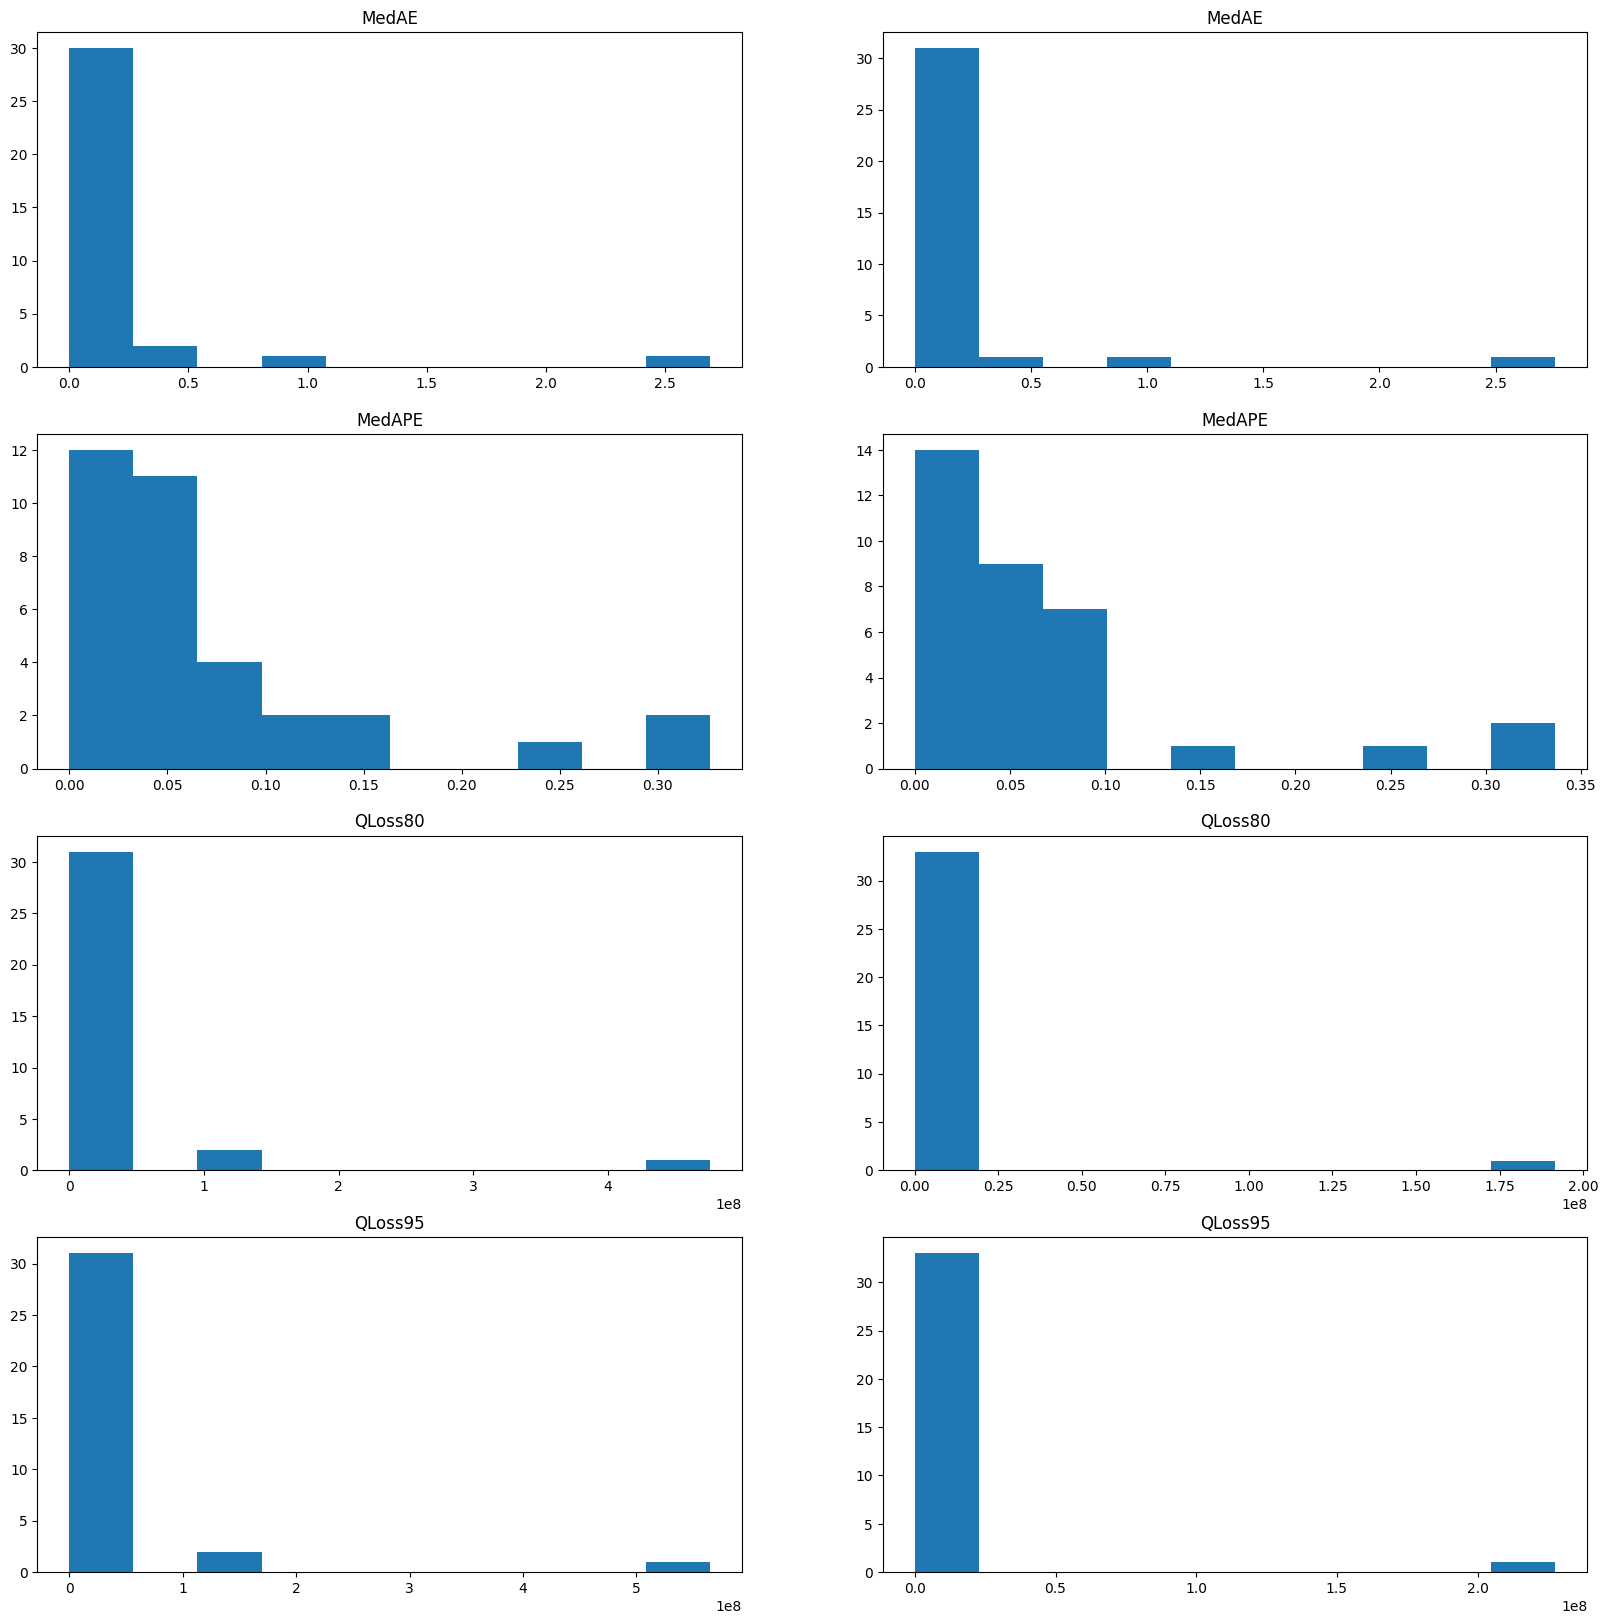

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))

for i, mname in enumerate(['MedAE', 'MedAPE', 'QLoss80', 'QLoss95']):
    axes[i, 0].hist(stats_matrix[0, :, i])
    axes[i, 1].hist(stats_matrix[1, :, i])
    
    axes[i, 0].set_title(mname)
    axes[i, 1].set_title(mname)

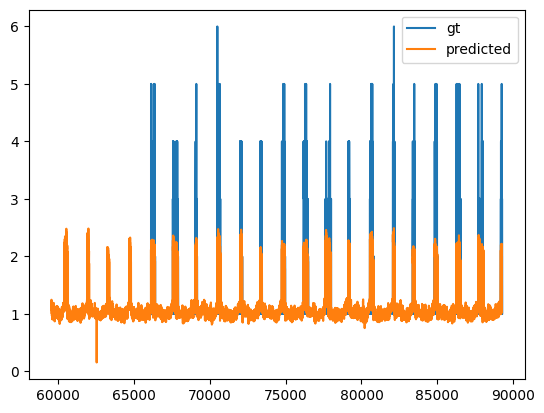

In [152]:
plt.plot(g_y[65000:].index.values, g_y[65000:], label='gt')
plt.plot(val_idx_, y_pred, label='predicted')
plt.legend()